In [66]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [67]:
#change the tickers here according to what's in the portfolio
tickers = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX"]

start_date = '2017-01-01'
end_date = '2021-12-31'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [68]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MGIC    1259 non-null   float64
 1   NSIT    1259 non-null   float64
 2   ON      1259 non-null   float64
 3   TTD     1259 non-null   float64
 4   IDXX    1259 non-null   float64
 5   BDSI    1259 non-null   float64
 6   CDMO    1259 non-null   float64
 7   ICLR    1259 non-null   float64
 8   MEDP    1259 non-null   float64
 9   OPRX    1259 non-null   float64
 10  RGEN    1259 non-null   float64
 11  TNDM    1259 non-null   float64
 12  XOMA    1259 non-null   float64
 13  CBRE    1259 non-null   float64
 14  SBAC    1259 non-null   float64
 15  ODFL    1259 non-null   float64
 16  GLDD    1259 non-null   float64
 17  HSON    1259 non-null   float64
 18  KRNT    1259 non-null   float64
 19  QRHC    1259 non-null   float64
 20  RCII    1259 non-null   float64
 21  SAIA    1259 non-nu

## Function that saves dataframe to CSV

In [69]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [70]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Close']
    save_dataframe_to_csv('close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [71]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [72]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [73]:
for ticker in tickers:
    df = get_df_from_csv('close', ticker)
    add_daily_return_to_df('close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [74]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [75]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Close'].item()

## Returns the value of portfolio by date

In [76]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [77]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [78]:
#change to the list of stocks we using
port_list = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX"]

#add in the weightage of stocks
port_shares = [0.056508,0.046601,0.006341,0.130548,0.038795,0.006555,0.015181,0.013922,0.004819,0.035141,0.037627,
              0.000394,0.007568,0.051494,0.108506,0.062501,0.000536,0.006388,0.006606,0.005183,0.002574,0.000174,
              0.002497,0.033541,0.001614,0.037578,0.009430,0.025462,0.004964,0.009947,0.031003,0.200000]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.389905,1.895729,0.080467,0.351566,4.562292,0.011471,0.031880,1.040113,0.173050,0.085393,...,0.090714,1.630810,0.467414,0.143573,0.200943,0.267077,2.072551,0.3888,32.394128,NaN
2017-01-04,0.392731,1.929281,0.082433,0.353785,4.498280,0.011471,0.032943,1.069488,0.175363,0.084338,...,0.093612,1.705966,0.468200,0.147385,0.201985,0.277521,2.151918,0.3894,32.686957,0.009040
2017-01-05,0.395556,1.894797,0.081482,0.358354,4.498668,0.012127,0.031880,1.060996,0.172665,0.085393,...,0.092514,1.704162,0.467885,0.146114,0.203276,0.278019,2.130836,0.3726,32.422003,-0.008106
2017-01-06,0.392731,1.868234,0.082496,0.361618,4.591776,0.012454,0.031880,1.094965,0.172617,0.085393,...,0.092757,1.721147,0.461284,0.151197,0.197170,0.275035,2.116575,0.3844,32.413547,-0.000261
2017-01-09,0.392731,1.863108,0.084589,0.371279,4.617381,0.012127,0.031880,1.118911,0.172135,0.083284,...,0.091933,1.738208,0.454840,0.152467,0.192702,0.273542,2.114095,0.3762,32.358261,-0.001706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.863442,3.474105,0.202849,12.164071,19.286547,0.028187,0.172912,2.680124,0.670516,1.109753,...,0.172520,24.867994,1.951161,0.392879,0.788531,1.060251,10.895075,0.0728,135.984120,0.007053
2020-12-28,0.856661,3.523502,0.202595,10.869688,19.191887,0.027269,0.172153,2.664392,0.666034,1.131892,...,0.173311,24.940143,1.956914,0.394152,0.821840,1.062936,10.893214,0.0728,134.410415,-0.011573
2020-12-29,0.880395,3.477367,0.200756,10.708722,19.167446,0.026810,0.168813,2.693907,0.664396,1.091831,...,0.174231,25.026572,1.848186,0.380148,0.842838,1.048911,10.950880,0.0756,134.157111,-0.001885


## Get old data for portfolio

In [79]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', 
                                    port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.389905,1.895729,0.080467,0.351566,4.562292,0.011471,0.031880,1.040113,0.173050,0.085393,...,0.090714,1.630810,0.467414,0.143573,0.200943,0.267077,2.072551,0.3888,32.394128,NaN
2017-01-04,0.392731,1.929281,0.082433,0.353785,4.498280,0.011471,0.032943,1.069488,0.175363,0.084338,...,0.093612,1.705966,0.468200,0.147385,0.201985,0.277521,2.151918,0.3894,32.686957,0.009040
2017-01-05,0.395556,1.894797,0.081482,0.358354,4.498668,0.012127,0.031880,1.060996,0.172665,0.085393,...,0.092514,1.704162,0.467885,0.146114,0.203276,0.278019,2.130836,0.3726,32.422003,-0.008106
2017-01-06,0.392731,1.868234,0.082496,0.361618,4.591776,0.012454,0.031880,1.094965,0.172617,0.085393,...,0.092757,1.721147,0.461284,0.151197,0.197170,0.275035,2.116575,0.3844,32.413547,-0.000261
2017-01-09,0.392731,1.863108,0.084589,0.371279,4.617381,0.012127,0.031880,1.118911,0.172135,0.083284,...,0.091933,1.738208,0.454840,0.152467,0.192702,0.273542,2.114095,0.3762,32.358261,-0.001706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.863442,3.474105,0.202849,12.164071,19.286547,0.028187,0.172912,2.680124,0.670516,1.109753,...,0.172520,24.867994,1.951161,0.392879,0.788531,1.060251,10.895075,0.0728,135.984120,0.007053
2020-12-28,0.856661,3.523502,0.202595,10.869688,19.191887,0.027269,0.172153,2.664392,0.666034,1.131892,...,0.173311,24.940143,1.956914,0.394152,0.821840,1.062936,10.893214,0.0728,134.410415,-0.011573
2020-12-29,0.880395,3.477367,0.200756,10.708722,19.167446,0.026810,0.168813,2.693907,0.664396,1.091831,...,0.174231,25.026572,1.848186,0.380148,0.842838,1.048911,10.950880,0.0756,134.157111,-0.001885


## Forecasting

In [80]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [81]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [82]:
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.389905,1.895729,0.080467,0.351566,4.562292,0.011471,0.031880,1.040113,0.173050,0.085393,...,0.090714,1.630810,0.467414,0.143573,0.200943,0.267077,2.072551,0.3888,32.394128,NaN
2017-01-04,0.392731,1.929281,0.082433,0.353785,4.498280,0.011471,0.032943,1.069488,0.175363,0.084338,...,0.093612,1.705966,0.468200,0.147385,0.201985,0.277521,2.151918,0.3894,32.686957,0.009040
2017-01-05,0.395556,1.894797,0.081482,0.358354,4.498668,0.012127,0.031880,1.060996,0.172665,0.085393,...,0.092514,1.704162,0.467885,0.146114,0.203276,0.278019,2.130836,0.3726,32.422003,-0.008106
2017-01-06,0.392731,1.868234,0.082496,0.361618,4.591776,0.012454,0.031880,1.094965,0.172617,0.085393,...,0.092757,1.721147,0.461284,0.151197,0.197170,0.275035,2.116575,0.3844,32.413547,-0.000261
2017-01-07,0.392731,1.868234,0.082496,0.361618,4.591776,0.012454,0.031880,1.094965,0.172617,0.085393,...,0.092757,1.721147,0.461284,0.151197,0.197170,0.275035,2.116575,0.3844,32.413547,-0.000261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.863442,3.474105,0.202849,12.164071,19.286547,0.028187,0.172912,2.680124,0.670516,1.109753,...,0.172520,24.867994,1.951161,0.392879,0.788531,1.060251,10.895075,0.0728,135.984120,0.007053
2020-12-28,0.856661,3.523502,0.202595,10.869688,19.191887,0.027269,0.172153,2.664392,0.666034,1.131892,...,0.173311,24.940143,1.956914,0.394152,0.821840,1.062936,10.893214,0.0728,134.410415,-0.011573
2020-12-29,0.880395,3.477367,0.200756,10.708722,19.167446,0.026810,0.168813,2.693907,0.664396,1.091831,...,0.174231,25.026572,1.848186,0.380148,0.842838,1.048911,10.950880,0.0756,134.157111,-0.001885


In [83]:
# Delete all unneeded columns - basically delete all except Total
del_col = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [84]:
tot_port_df

,Total
Date,
2017-01-03,32.394128
2017-01-04,32.686957
2017-01-05,32.422003
2017-01-06,32.413547
2017-01-07,32.413547
...,...
2020-12-27,135.984120
2020-12-28,134.410415
2020-12-29,134.157111


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1459


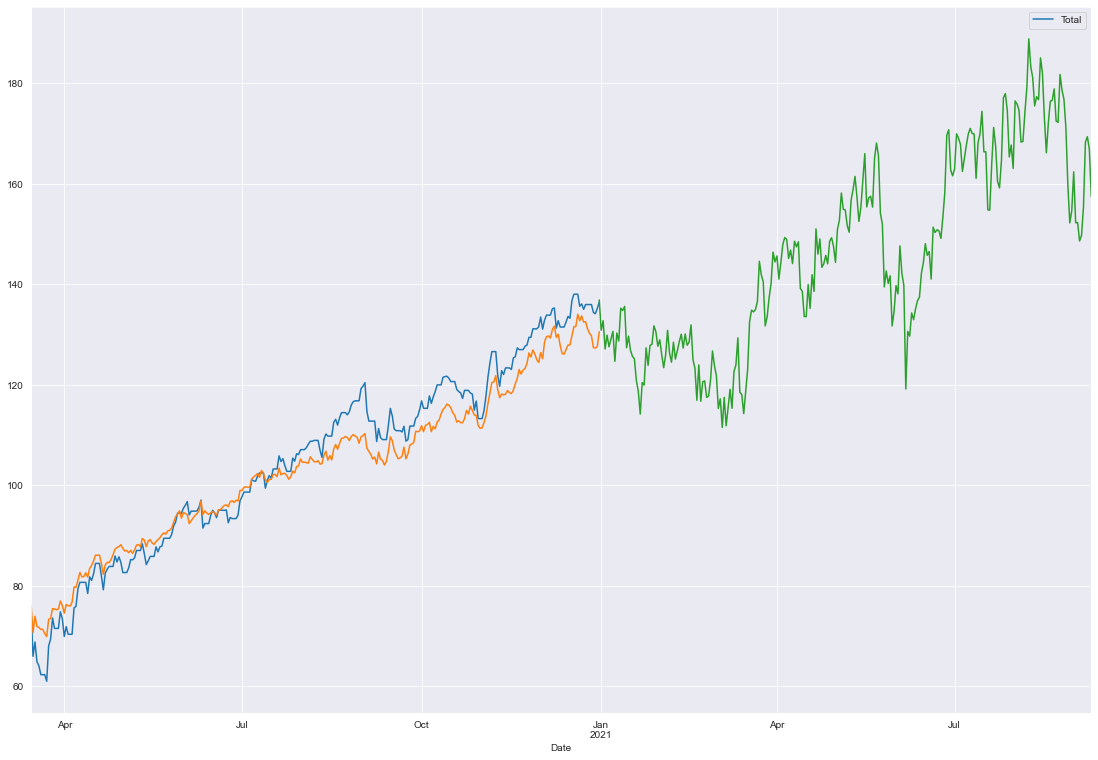

In [85]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1167] # First 80% 
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [86]:
forecast

2020-12-31    136.901260
2021-01-01    130.864363
2021-01-02    132.770418
2021-01-03    127.148855
2021-01-04    129.894341
                 ...    
2021-09-05    155.392405
2021-09-06    168.323175
2021-09-07    169.399267
2021-09-08    166.954750
2021-09-09    157.496793
Freq: D, Length: 253, dtype: float64

In [87]:
forecast_df = pd.DataFrame(forecast)

In [88]:
forecast_df

,0
2020-12-31,136.901260
2021-01-01,130.864363
2021-01-02,132.770418
2021-01-03,127.148855
2021-01-04,129.894341
...,...
2021-09-05,155.392405
2021-09-06,168.323175
2021-09-07,169.399267
2021-09-08,166.954750


In [89]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [90]:
return_series

,0
2020-12-31,NaN
2021-01-01,-0.044097
2021-01-02,-0.030174
2021-01-03,-0.071237
2021-01-04,-0.051182
...,...
2021-09-05,0.135069
2021-09-06,0.229522
2021-09-07,0.237383
2021-09-08,0.219527


In [91]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2021-09-09  15.044078


In [92]:
#calculate annualized volatility
annualized_vol = np.sqrt(np.log(forecast / forecast.shift(1)).var()) * np.sqrt(252)
annualized_vol*100

57.0357327232411

## Backtesting

In [93]:
tickers2 = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX"]

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2020-12-31'
end_date = '2021-12-30'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [94]:
panel_data2 = panel_data2['Close']

In [95]:
panel_data2

Symbols,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,SBLK,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,15.730000,75.440002,32.480000,81.800003,496.959991,4.27,11.640000,193.660004,137.860001,31.200001,...,8.590000,33.610001,110.180000,694.780029,198.429993,15.180000,172.740005,107.250000,350.779999,0.370
2020-12-31,15.650000,76.089996,32.730000,80.099998,499.869995,4.20,11.540000,194.979996,139.199997,31.160000,...,8.830000,34.680000,111.260002,705.669983,194.789993,15.400000,174.979996,105.709999,348.029999,0.361
2021-01-04,14.960000,75.279999,32.669998,77.343002,491.769989,4.29,11.860000,192.020004,134.419998,33.360001,...,8.860000,34.169998,107.459999,729.770020,188.389999,15.150000,167.089996,103.410004,356.399994,0.354
2021-01-05,14.900000,76.860001,33.220001,78.853996,497.260010,4.44,12.920000,195.690002,133.990005,34.590000,...,9.370000,34.900002,107.949997,735.109985,196.440002,15.490000,172.490005,108.160004,366.500000,0.377
2021-01-06,14.640000,79.989998,34.060001,74.060997,483.600006,4.50,13.280000,205.479996,139.880005,35.410000,...,9.300000,34.889999,110.769997,755.979980,205.520004,16.549999,182.380005,113.449997,363.250000,0.432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,20.910000,103.220001,66.760002,96.050003,645.020020,3.22,29.540001,307.929993,223.369995,60.490002,...,21.049999,92.900002,154.710007,1067.000000,236.369995,26.670000,193.559998,163.690002,391.559998,1.243
2021-12-27,21.410000,104.000000,69.779999,97.680000,654.840027,3.15,30.270000,307.619995,227.899994,63.349998,...,21.180000,96.000000,155.289993,1093.939941,237.190002,27.160000,196.960007,165.490005,400.750000,1.252
2021-12-28,21.070000,104.279999,68.320000,94.790001,651.280029,3.11,29.280001,306.049988,218.300003,60.730000,...,21.010000,93.010002,155.020004,1088.469971,238.820007,27.209999,196.470001,164.350006,400.070007,1.245


## Portfolio Analysis

In [96]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,SBLK,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,-0.005086,0.008616,0.007697,-0.020782,0.005856,-0.016393,-0.008591,0.006816,0.009720,-0.001282,...,0.027939,0.031836,0.009802,0.015674,-0.018344,0.014493,0.012967,-0.014359,-0.007840,-0.024324
2021-01-04,-0.044089,-0.010645,-0.001833,-0.034419,-0.016204,0.021429,0.027730,-0.015181,-0.034339,0.070603,...,0.003397,-0.014706,-0.034154,0.034152,-0.032856,-0.016234,-0.045091,-0.021758,0.024050,-0.019391
2021-01-05,-0.004011,0.020988,0.016835,0.019536,0.011164,0.034965,0.089376,0.019113,-0.003199,0.036870,...,0.057562,0.021364,0.004560,0.007317,0.042731,0.022442,0.032318,0.045934,0.028339,0.064972
2021-01-06,-0.017450,0.040723,0.025286,-0.060783,-0.027471,0.013514,0.027864,0.050028,0.043958,0.023706,...,-0.007471,-0.000287,0.026123,0.028390,0.046223,0.068431,0.057337,0.048909,-0.008868,0.145889
2021-01-07,0.019126,0.016377,0.038168,0.030272,0.023966,0.082222,-0.003012,0.019321,0.000143,0.059023,...,0.054839,0.001433,0.022750,0.079447,0.023015,0.004834,0.010582,0.041869,0.011122,0.050926


In [97]:
portfolio_weights = [0.056508,0.046601,0.006341,0.130548,0.038795,0.006555,0.015181,0.013922,0.004819,0.035141,0.037627,
              0.000394,0.007568,0.051494,0.108506,0.062501,0.000536,0.006388,0.006606,0.005183,0.002574,0.000174,
              0.002497,0.033541,0.001614,0.037578,0.009430,0.025462,0.004964,0.009947,0.031003,0.200000]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,SBLK,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,-0.000287,0.000402,0.000049,-0.002713,0.000227,-0.000107,-0.000130,0.000095,4.684058e-05,-0.000045,...,0.000070,0.001068,0.000016,0.000589,-0.000173,0.000369,0.000064,-0.000143,-0.000243,-0.004865
2021-01-04,-0.002491,-0.000496,-0.000012,-0.004493,-0.000629,0.000140,0.000421,-0.000211,-1.654800e-04,0.002481,...,0.000008,-0.000493,-0.000055,0.001283,-0.000310,-0.000413,-0.000224,-0.000216,0.000746,-0.003878
2021-01-05,-0.000227,0.000978,0.000107,0.002550,0.000433,0.000229,0.001357,0.000266,-1.541538e-05,0.001296,...,0.000144,0.000717,0.000007,0.000275,0.000403,0.000571,0.000160,0.000457,0.000879,0.012994
2021-01-06,-0.000986,0.001898,0.000160,-0.007935,-0.001066,0.000089,0.000423,0.000696,2.118360e-04,0.000833,...,-0.000019,-0.000010,0.000042,0.001067,0.000436,0.001742,0.000285,0.000486,-0.000275,0.029178
2021-01-07,0.001081,0.000763,0.000242,0.003952,0.000930,0.000539,-0.000046,0.000269,6.886406e-07,0.002074,...,0.000137,0.000048,0.000037,0.002985,0.000217,0.000123,0.000053,0.000416,0.000345,0.010185


In [98]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2020-12-31   -0.001873
2021-01-04   -0.016984
2021-01-05    0.024020
2021-01-06    0.026187
2021-01-07    0.030219
dtype: float64

Start date,2020-12-31
End date,2021-12-30
Total months,12
,Backtest
Annual return,95.3%
Cumulative returns,95.3%
Annual volatility,23.5%
Sharpe ratio,2.97
Calmar ratio,9.89
Stability,0.95
Max drawdown,-9.6%


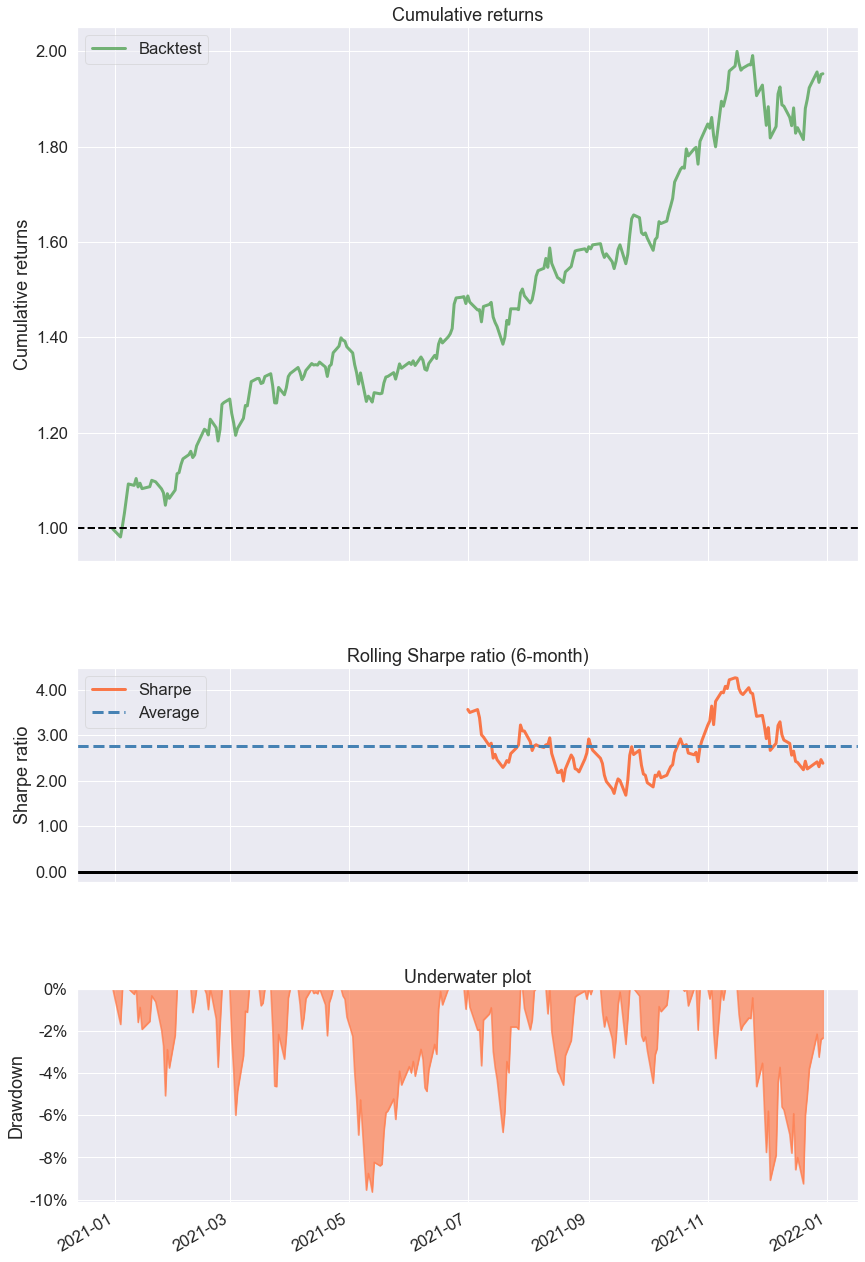

In [99]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

## Extra stuff

In [100]:
import itertools

In [101]:
weights = [0.056508,0.046601,0.006341,0.130548,0.038795,0.006555,0.015181,0.013922,0.004819,0.035141,0.037627,
              0.000394,0.007568,0.051494,0.108506,0.062501,0.000536,0.006388,0.006606,0.005183,0.002574,0.000174,
              0.002497,0.033541,0.001614,0.037578,0.009430,0.025462,0.004964,0.009947,0.031003,0.200000]

In [102]:
panel_data2 = panel_data2 * weights

In [103]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [104]:
#forecasted portfolio value
panel_data2

Symbols,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,0.888871,3.515580,0.205956,10.678827,19.279563,0.027990,0.176707,2.696135,0.664347,1.096399,...,1.127313,0.177831,26.108444,1.871195,0.386513,0.857481,1.066816,10.875232,0.0740,135.207177
2020-12-31,0.884350,3.545870,0.207541,10.456895,19.392456,0.027531,0.175189,2.714512,0.670805,1.094994,...,1.163202,0.179574,26.517667,1.836870,0.392115,0.868601,1.051497,10.789974,0.0722,136.492388
2021-01-04,0.845360,3.508123,0.207160,10.096974,19.078217,0.028121,0.180047,2.673302,0.647770,1.172304,...,1.146096,0.173440,27.423298,1.776518,0.385749,0.829435,1.028619,11.049469,0.0708,135.500299
2021-01-05,0.841969,3.581753,0.210648,10.294232,19.291202,0.029104,0.196139,2.724396,0.645698,1.215527,...,1.170581,0.174231,27.623963,1.852429,0.394406,0.856240,1.075868,11.362599,0.0754,136.709812
2021-01-06,0.827277,3.727614,0.215974,9.668515,18.761262,0.029497,0.201604,2.860693,0.674082,1.244343,...,1.170245,0.178783,28.408216,1.938054,0.421396,0.905334,1.128487,11.261840,0.0864,136.191890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,1.181582,4.810155,0.423325,12.539136,25.023552,0.021107,0.448447,4.287001,1.076420,2.125679,...,3.115959,0.249702,40.095726,2.228969,0.679072,0.960832,1.628224,12.139535,0.2486,192.707263
2021-12-27,1.209836,4.846504,0.442475,12.751929,25.404519,0.020648,0.459529,4.282686,1.098250,2.226182,...,3.219936,0.250638,41.108075,2.236702,0.691548,0.977709,1.646129,12.424452,0.2504,196.697289
2021-12-28,1.190624,4.859552,0.433217,12.374645,25.266409,0.020386,0.444500,4.260828,1.051988,2.134113,...,3.119648,0.250202,40.902525,2.252073,0.692821,0.975277,1.634790,12.403370,0.2490,195.338608


In [105]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [106]:
actual_portfolio_value

[135.2071774344506,
 136.49238787658643,
 135.5002985781765,
 136.7098122748594,
 136.1918902608178,
 140.59780660853653,
 144.92985101247294,
 140.61846042617844,
 142.2477611982191,
 142.15001572214246,
 141.9113486694839,
 141.83006727154586,
 142.72911086684826,
 144.75613527743047,
 144.3195182509613,
 144.26078016320037,
 145.35023224539185,
 143.72797313590283,
 139.69982151476646,
 140.34333914845294,
 137.42795223237803,
 142.33852426994608,
 146.4875771798365,
 143.32746707890007,
 145.12695791276383,
 146.17638160154246,
 146.06484221160267,
 146.29280087218498,
 144.6710428190231,
 145.72450429580357,
 146.868487375716,
 145.09311148065783,
 144.5397377266014,
 144.9885202500341,
 145.640686748801,
 141.08773869765068,
 138.0617317414784,
 140.66861379924347,
 136.81439551122403,
 137.34507193058326,
 140.74447021143698,
 138.17753672222187,
 132.3154384246416,
 127.2443246189494,
 128.71841091864087,
 126.7311530255458,
 133.71322053204582,
 134.37202430788543,
 138.485779

In [107]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [108]:
forecasted_portfolio_value

[136.90125977167935,
 130.86436335296926,
 132.77041849031562,
 127.14885491689958,
 129.8943409147191,
 127.5681088764628,
 129.13002228677792,
 130.64692436724633,
 124.68147753541848,
 130.30464921213067,
 128.71689243336417,
 135.26338438555814,
 134.80517537490906,
 135.6217012580878,
 127.37922512256836,
 129.68332347834942,
 126.88483568502943,
 125.66241430688784,
 125.19604209065352,
 120.89926683159642,
 118.73034418477931,
 114.1865660235199,
 120.4489208374973,
 119.94569707965674,
 127.36213568825583,
 123.87573567949046,
 127.84405772015528,
 128.07707504788175,
 131.74832055877974,
 130.59400740549086,
 127.68827881245798,
 128.9670053284205,
 125.98727861337497,
 123.40742300851332,
 125.93871853060482,
 130.85857680860482,
 126.30511959478328,
 124.50537966042562,
 128.48546904349607,
 125.12958447305317,
 126.79701811719846,
 128.6262685836064,
 130.08359563386688,
 127.30376905486251,
 130.12479256746866,
 127.89325985030922,
 128.44082945765413,
 131.924869158947,
 

## Calculate MAPE of forecasted period

In [109]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.09
MAPE % : 9.07 %



## Mean Squared Error

In [110]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value))

319.62365000717875


## Forecast for future

In [111]:
#change to the list of stocks we using
port_list = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX"]

#add in the weightage of stocks
port_shares = [0.056508,0.046601,0.006341,0.130548,0.038795,0.006555,0.015181,0.013922,0.004819,0.035141,0.037627,
              0.000394,0.007568,0.051494,0.108506,0.062501,0.000536,0.006388,0.006606,0.005183,0.002574,0.000174,
              0.002497,0.033541,0.001614,0.037578,0.009430,0.025462,0.004964,0.009947,0.031003,0.200000]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.389905,1.895729,0.080467,0.351566,4.562292,0.011471,0.031880,1.040113,0.173050,0.085393,...,0.090714,1.630810,0.467414,0.143573,0.200943,0.267077,2.072551,0.3888,32.394128,NaN
2017-01-04,0.392731,1.929281,0.082433,0.353785,4.498280,0.011471,0.032943,1.069488,0.175363,0.084338,...,0.093612,1.705966,0.468200,0.147385,0.201985,0.277521,2.151918,0.3894,32.686957,0.009040
2017-01-05,0.395556,1.894797,0.081482,0.358354,4.498668,0.012127,0.031880,1.060996,0.172665,0.085393,...,0.092514,1.704162,0.467885,0.146114,0.203276,0.278019,2.130836,0.3726,32.422003,-0.008106
2017-01-06,0.392731,1.868234,0.082496,0.361618,4.591776,0.012454,0.031880,1.094965,0.172617,0.085393,...,0.092757,1.721147,0.461284,0.151197,0.197170,0.275035,2.116575,0.3844,32.413547,-0.000261
2017-01-09,0.392731,1.863108,0.084589,0.371279,4.617381,0.012127,0.031880,1.118911,0.172135,0.083284,...,0.091933,1.738208,0.454840,0.152467,0.192702,0.273542,2.114095,0.3762,32.358261,-0.001706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.209836,4.846504,0.442475,12.751929,25.404519,0.020648,0.459529,4.282686,1.098250,2.226182,...,0.250638,41.108075,2.236702,0.691548,0.977709,1.646129,12.424452,0.2504,196.697289,0.020705
2021-12-28,1.190624,4.859552,0.433217,12.374645,25.266409,0.020386,0.444500,4.260828,1.051988,2.134113,...,0.250202,40.902525,2.252073,0.692821,0.975277,1.634790,12.403370,0.2490,195.338608,-0.006907
2021-12-29,1.192884,4.942502,0.437085,12.084828,25.437494,0.020320,0.460136,4.287837,1.062445,2.090538,...,0.250767,40.816846,2.258862,0.691803,1.023477,1.642847,12.432203,0.2588,195.846235,0.002599


In [112]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', 
                                    port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.389905,1.895729,0.080467,0.351566,4.562292,0.011471,0.031880,1.040113,0.173050,0.085393,...,0.090714,1.630810,0.467414,0.143573,0.200943,0.267077,2.072551,0.3888,32.394128,NaN
2017-01-04,0.392731,1.929281,0.082433,0.353785,4.498280,0.011471,0.032943,1.069488,0.175363,0.084338,...,0.093612,1.705966,0.468200,0.147385,0.201985,0.277521,2.151918,0.3894,32.686957,0.009040
2017-01-05,0.395556,1.894797,0.081482,0.358354,4.498668,0.012127,0.031880,1.060996,0.172665,0.085393,...,0.092514,1.704162,0.467885,0.146114,0.203276,0.278019,2.130836,0.3726,32.422003,-0.008106
2017-01-06,0.392731,1.868234,0.082496,0.361618,4.591776,0.012454,0.031880,1.094965,0.172617,0.085393,...,0.092757,1.721147,0.461284,0.151197,0.197170,0.275035,2.116575,0.3844,32.413547,-0.000261
2017-01-09,0.392731,1.863108,0.084589,0.371279,4.617381,0.012127,0.031880,1.118911,0.172135,0.083284,...,0.091933,1.738208,0.454840,0.152467,0.192702,0.273542,2.114095,0.3762,32.358261,-0.001706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.209836,4.846504,0.442475,12.751929,25.404519,0.020648,0.459529,4.282686,1.098250,2.226182,...,0.250638,41.108075,2.236702,0.691548,0.977709,1.646129,12.424452,0.2504,196.697289,0.020705
2021-12-28,1.190624,4.859552,0.433217,12.374645,25.266409,0.020386,0.444500,4.260828,1.051988,2.134113,...,0.250202,40.902525,2.252073,0.692821,0.975277,1.634790,12.403370,0.2490,195.338608,-0.006907
2021-12-29,1.192884,4.942502,0.437085,12.084828,25.437494,0.020320,0.460136,4.287837,1.062445,2.090538,...,0.250767,40.816846,2.258862,0.691803,1.023477,1.642847,12.432203,0.2588,195.846235,0.002599


In [113]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [114]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [115]:
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.389905,1.895729,0.080467,0.351566,4.562292,0.011471,0.031880,1.040113,0.173050,0.085393,...,0.090714,1.630810,0.467414,0.143573,0.200943,0.267077,2.072551,0.3888,32.394128,NaN
2017-01-04,0.392731,1.929281,0.082433,0.353785,4.498280,0.011471,0.032943,1.069488,0.175363,0.084338,...,0.093612,1.705966,0.468200,0.147385,0.201985,0.277521,2.151918,0.3894,32.686957,0.009040
2017-01-05,0.395556,1.894797,0.081482,0.358354,4.498668,0.012127,0.031880,1.060996,0.172665,0.085393,...,0.092514,1.704162,0.467885,0.146114,0.203276,0.278019,2.130836,0.3726,32.422003,-0.008106
2017-01-06,0.392731,1.868234,0.082496,0.361618,4.591776,0.012454,0.031880,1.094965,0.172617,0.085393,...,0.092757,1.721147,0.461284,0.151197,0.197170,0.275035,2.116575,0.3844,32.413547,-0.000261
2017-01-07,0.392731,1.868234,0.082496,0.361618,4.591776,0.012454,0.031880,1.094965,0.172617,0.085393,...,0.092757,1.721147,0.461284,0.151197,0.197170,0.275035,2.116575,0.3844,32.413547,-0.000261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.209836,4.846504,0.442475,12.751929,25.404519,0.020648,0.459529,4.282686,1.098250,2.226182,...,0.250638,41.108075,2.236702,0.691548,0.977709,1.646129,12.424452,0.2504,196.697289,0.020705
2021-12-28,1.190624,4.859552,0.433217,12.374645,25.266409,0.020386,0.444500,4.260828,1.051988,2.134113,...,0.250202,40.902525,2.252073,0.692821,0.975277,1.634790,12.403370,0.2490,195.338608,-0.006907
2021-12-29,1.192884,4.942502,0.437085,12.084828,25.437494,0.020320,0.460136,4.287837,1.062445,2.090538,...,0.250767,40.816846,2.258862,0.691803,1.023477,1.642847,12.432203,0.2588,195.846235,0.002599


In [116]:
# Delete all unneeded columns - basically delete all except Total
del_col = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [117]:
tot_port_df

,Total
Date,
2017-01-03,32.394128
2017-01-04,32.686957
2017-01-05,32.422003
2017-01-06,32.413547
2017-01-07,32.413547
...,...
2021-12-27,196.697289
2021-12-28,195.338608
2021-12-29,195.846235


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1824


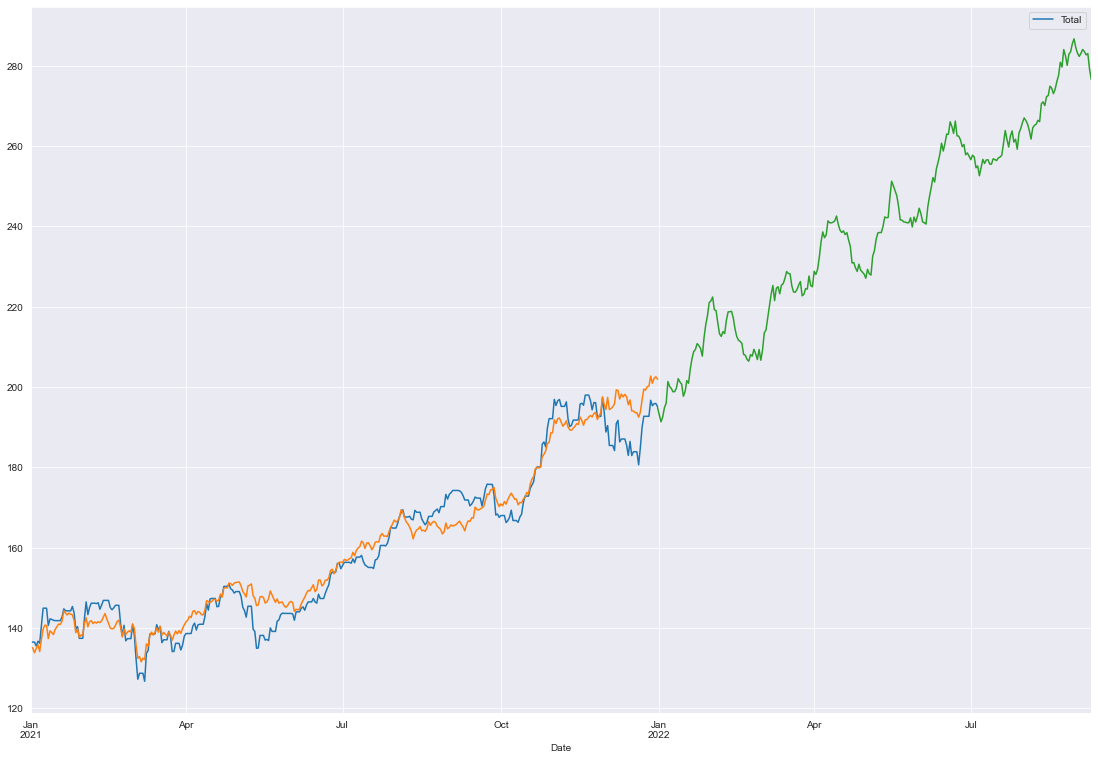

In [118]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [119]:
## Calculate annualized returns for forecasted

In [120]:
forecast

2021-12-31    194.858985
2022-01-01    193.043624
2022-01-02    191.325582
2022-01-03    192.554840
2022-01-04    194.871704
                 ...    
2022-09-05    283.492156
2022-09-06    282.684649
2022-09-07    283.020322
2022-09-08    279.111092
2022-09-09    276.543711
Freq: D, Length: 253, dtype: float64

In [121]:
forecast_df = pd.DataFrame(forecast)

In [122]:
forecast_df

,0
2021-12-31,194.858985
2022-01-01,193.043624
2022-01-02,191.325582
2022-01-03,192.554840
2022-01-04,194.871704
...,...
2022-09-05,283.492156
2022-09-06,282.684649
2022-09-07,283.020322
2022-09-08,279.111092


In [123]:
# return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [124]:
# return_series

In [125]:
#calculate annualized return
# total_return = return_series.tail(1)

# annualized_return = ((1 + total_return)**(1))-1

# print(annualized_return*100)

In [126]:
#calculate annualized volatility

In [127]:
annualised_vol = np.sqrt(np.log(forecast / forecast.shift(1)).var()) * np.sqrt(252)

In [128]:
annualised_vol*100

13.23912596635185